In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils


Using TensorFlow backend.


In [2]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [3]:
# ------- THE PROGRAM TO LOAD DATA AND TRAIN THE MODEL -------

# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]
# The number of steps within one time segment
TIME_PERIODS = 200#80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 100#40


keras version  2.3.1


In [4]:
df = read_data('../../Data/WISDM_ar_v1.1_raw.txt')
df.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2


In [5]:
show_basic_dataframe_info(df, 20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203

First 20 rows of the dataframe:

    user-id activity       timestamp  x-axis  y-axis  z-axis
0        33  Jogging  49105962326000    -0.7    12.7     0.5
1        33  Jogging  49106062271000     5.0    11.3     1.0
2        33  Jogging  49106112167000     4.9    10.9    -0.1
3        33  Jogging  49106222305000    -0.6    18.5     3.0
4        33  Jogging  49106332290000    -1.2    12.1     7.2
5        33  Jogging  49106442306000     1.4    -2.5    -6.5
6        33  Jogging  49106542312000    -0.6    10.6     5.7
7        33  Jogging  49106652389000    -0.5    13.9     7.1
8        33  Jogging  49106762313000    -8.4    11.4     5.1
9        33  Jogging  49106872299000     1.0     1.4     1.6
10       33  Jogging  49106982315000    -8.2    19.6     2.7
11       33  Jogging  49107092330000     1.4     5.8     3.0
12       33  Jogging  49107202316000    -1.9    -3.0    -0.3
13       33  Jogging  49107312332

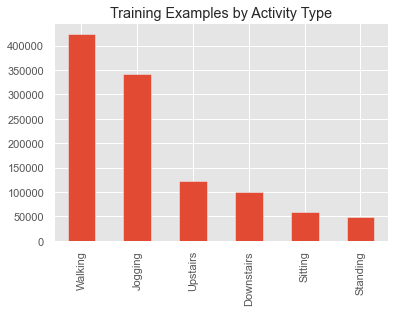

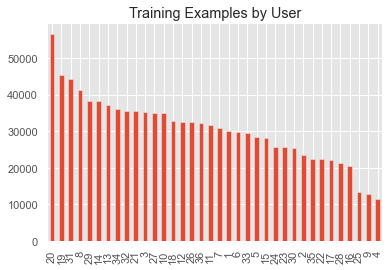

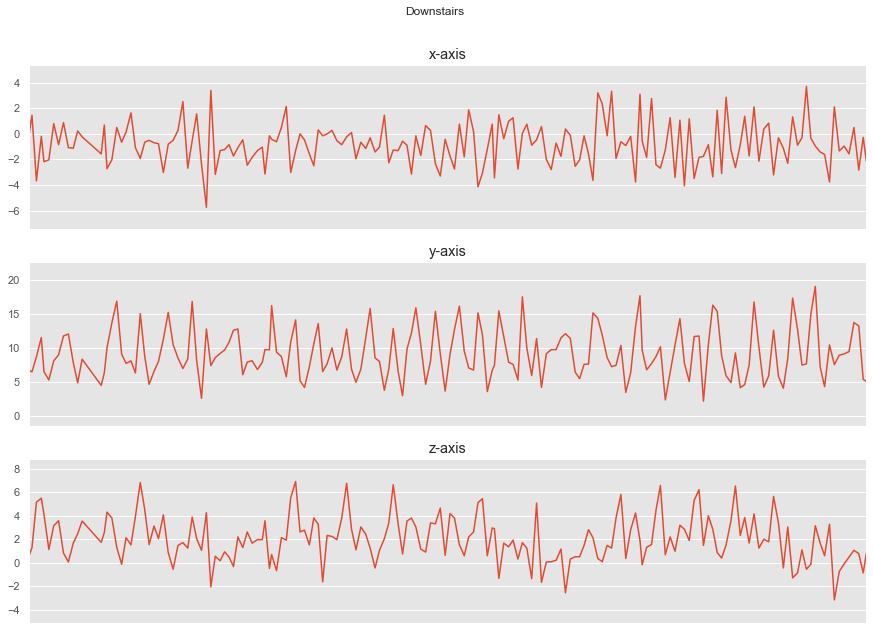

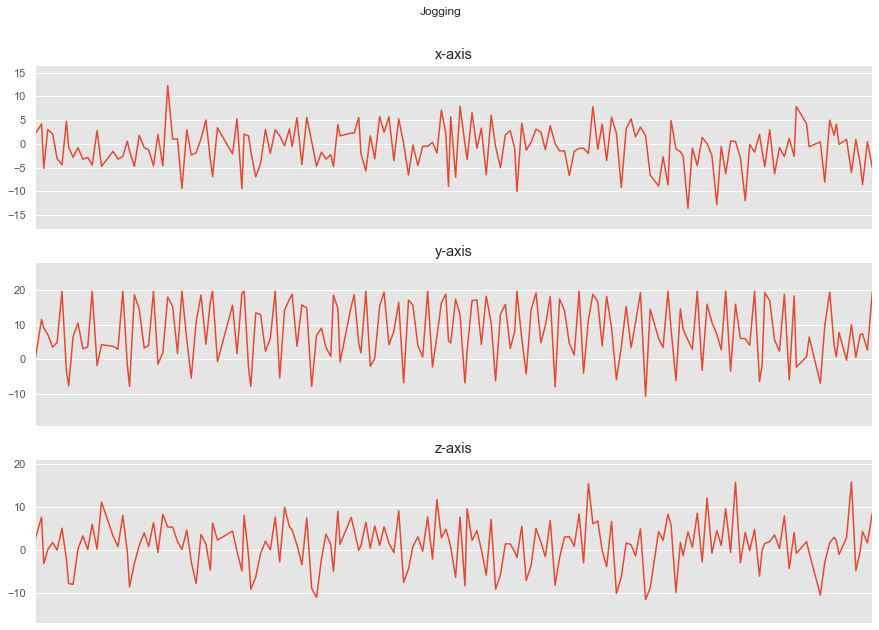

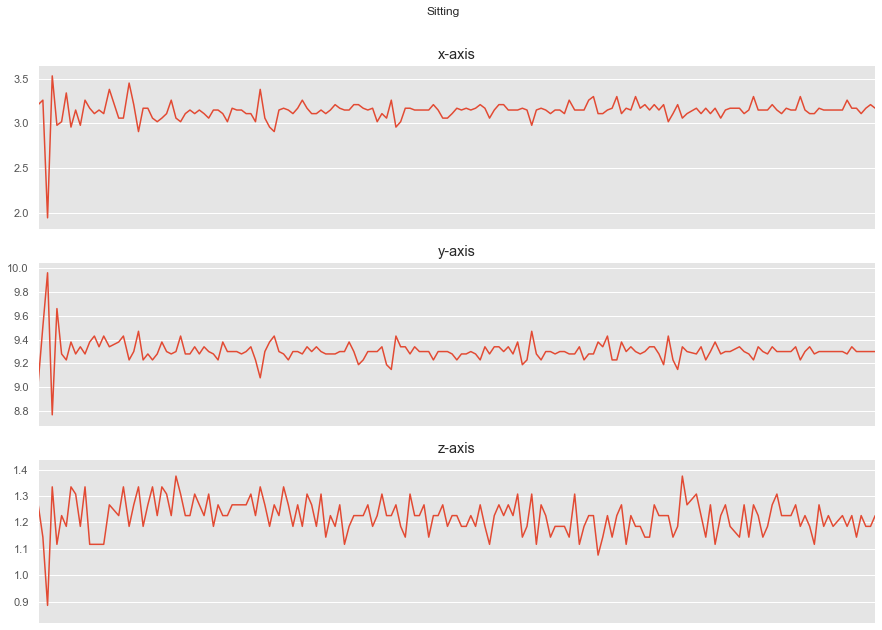

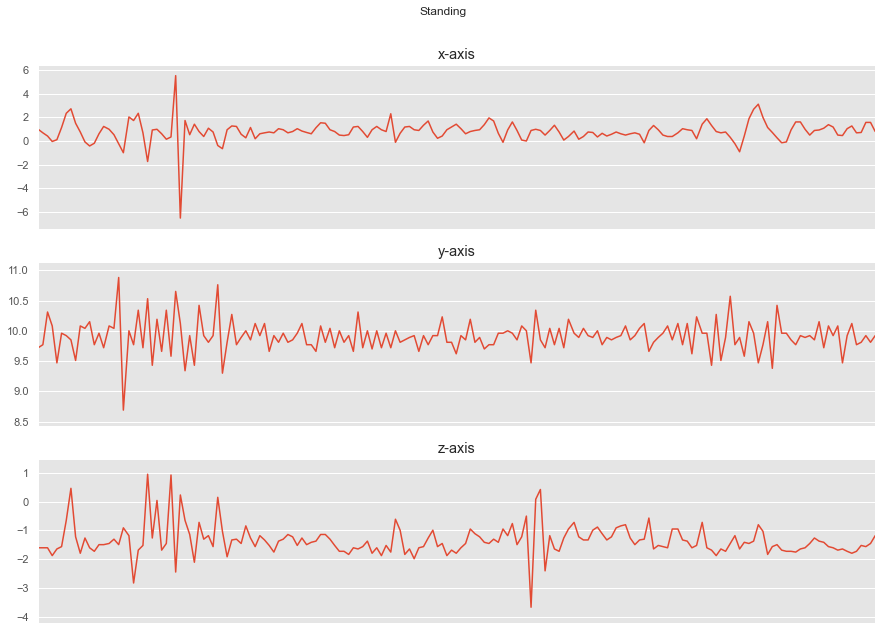

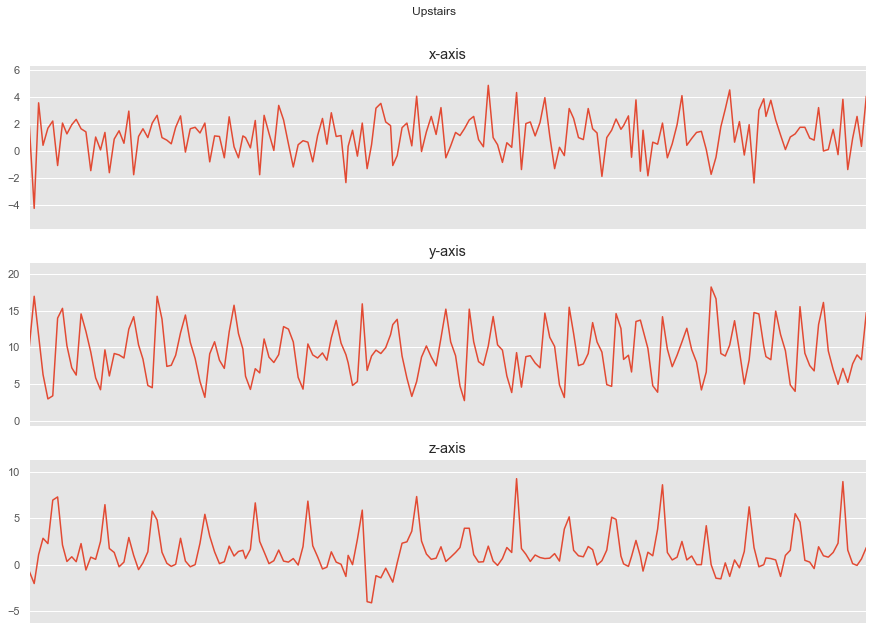

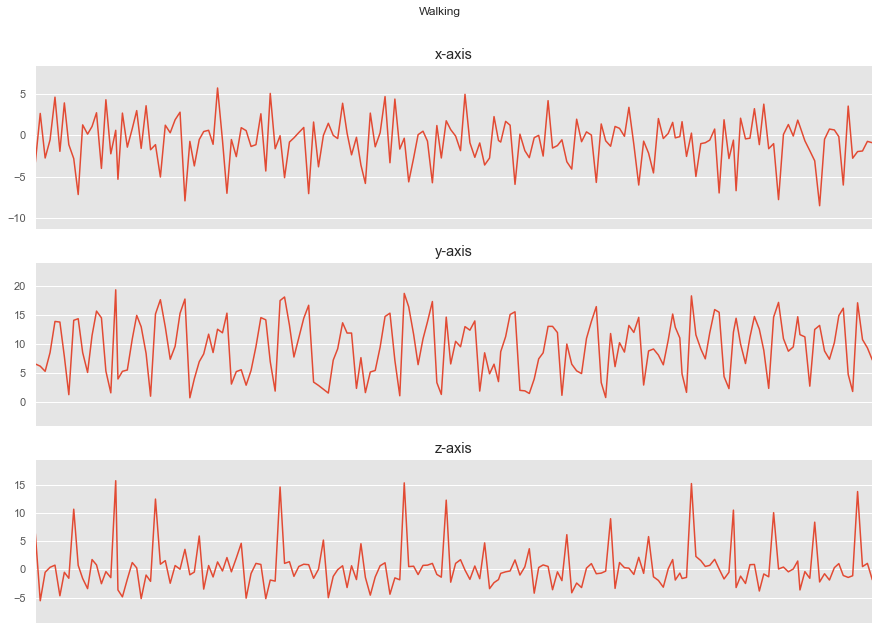

In [6]:
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][100:280]
    plot_activity(activity, subset)

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [7]:
df[df['user-id']<=700]['user-id'].unique()

array([33, 17, 20, 29, 13, 15,  6, 27, 36, 18, 32, 35, 11, 16,  5, 10, 28,
       26, 14, 24, 12, 23,  4, 30, 34,  8, 31, 21,  3, 22,  1,  9, 25,  2,
        7, 19])

In [8]:
print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

# Normalize features for training data set
df_train['x-axis'] = feature_normalize(df['x-axis'])
df_train['y-axis'] = feature_normalize(df['y-axis'])
df_train['z-axis'] = feature_normalize(df['z-axis'])
# Round in order to comply to NSNumber from iOS
df_train = df_train.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)


--- Reshape the data into segments ---



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [9]:
print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
# Displays (20869, 40, 3)
print(x_train.shape[0], 'training samples')
# Displays 20869 train samples

# Inspect y data
print('y_train shape: ', y_train.shape)
# Displays (20869,)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

# Set input_shape / reshape for Keras
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [40,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods*num_sensors)
# x_train = x_train.reshape(x_train.shape[0], input_shape)


# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# %%

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)
# (4173, 6)



--- Reshape data to be accepted by Keras ---

x_train shape:  (8346, 200, 3)
8346 training samples
y_train shape:  (8346,)
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
New y_train shape:  (8346, 6)


In [10]:
print("\n--- Create neural network model ---\n")
from tensorflow.keras.layers import BatchNormalization
# 1D CNN neural network
model_m = Sequential()
# model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(90, 5, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(90, 5, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(50, 5, activation='relu'))
model_m.add(BatchNormalization())

model_m.add(Conv1D(50, 5, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(BatchNormalization())

model_m.add(Conv1D(20, 5, activation='relu'))
model_m.add(BatchNormalization())

model_m.add(MaxPooling1D(3))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())


--- Create neural network model ---

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 196, 90)           1440      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 192, 90)           40590     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 90)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 50)            22550     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 50)            200       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 56, 50)            12550     
_________________________________________________________________
max_pooling1d_1 (M

In [11]:
print("\n--- Fit the model ---\n")
from tensorflow.keras import optimizers
# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
#     keras.callbacks.ModelCheckpoint(
#         filepath='best_model_91_BN_3.{epoch:02d}-{val_loss:.2f}.h5',
#         monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

adam = optimizers.Adam(lr=0.0001)

model_m.compile(loss='categorical_crossentropy',
                optimizer=adam, metrics=['accuracy'])



--- Fit the model ---



In [12]:
BATCH_SIZE = 500
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


Train on 6676 samples, validate on 1670 samples
Epoch 1/50
6676/6676 [==============================] - 13s 2ms/sample - loss: 1.4004 - accuracy: 0.5738 - val_loss: 1.7592 - val_accuracy: 0.3551
Epoch 2/50
6676/6676 [==============================] - 13s 2ms/sample - loss: 0.8516 - accuracy: 0.7531 - val_loss: 1.7343 - val_accuracy: 0.3659
Epoch 3/50
6676/6676 [==============================] - 12s 2ms/sample - loss: 0.7033 - accuracy: 0.7714 - val_loss: 1.7232 - val_accuracy: 0.3659
Epoch 4/50
6676/6676 [==============================] - 11s 2ms/sample - loss: 0.6017 - accuracy: 0.7996 - val_loss: 1.7248 - val_accuracy: 0.3461
Epoch 5/50
6676/6676 [==============================] - 11s 2ms/sample - loss: 0.5254 - accuracy: 0.8294 - val_loss: 1.7211 - val_accuracy: 0.3222
Epoch 6/50
6676/6676 [==============================] - 13s 2ms/sample - loss: 0.4684 - accuracy: 0.8474 - val_loss: 1.7155 - val_accuracy: 0.3096
Epoch 7/50
6676/6676 [==============================] - 12s 2ms/sample


--- Learning curve of model training ---



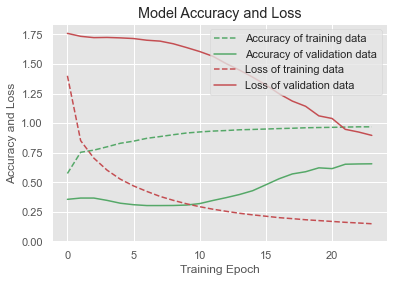

In [14]:
print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [15]:
print("\n--- Check against test data ---\n")

# Normalize features for training data set
df_test['x-axis'] = feature_normalize(df_test['x-axis'])
df_test['y-axis'] = feature_normalize(df_test['y-axis'])
df_test['z-axis'] = feature_normalize(df_test['z-axis'])

df_test = df_test.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
# x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])



--- Check against test data ---



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

2633/2633 [==============================] - 1s 507us/sample - loss: 0.7247 - accuracy: 0.7869

Accuracy on test data: 0.79

Loss on test data: 0.72



--- Confusion matrix for test data ---



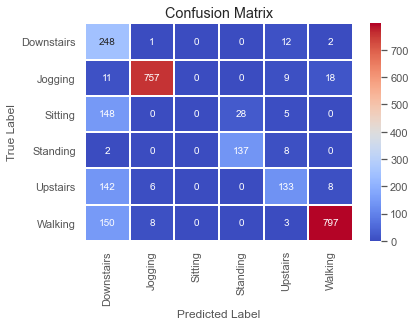

In [16]:
print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

In [17]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.35      0.94      0.51       263
           1       0.98      0.95      0.97       795
           2       0.00      0.00      0.00       181
           3       0.83      0.93      0.88       147
           4       0.78      0.46      0.58       289
           5       0.97      0.83      0.89       958

    accuracy                           0.79      2633
   macro avg       0.65      0.69      0.64      2633
weighted avg       0.82      0.79      0.78      2633



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Adding more Convolutions 

In [18]:
print("\n--- Create neural network model ---\n")
from tensorflow.keras.layers import BatchNormalization
# 1D CNN neural network
model_m = Sequential()
# model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(140, 5, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(140, 5, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(70, 5, activation='relu'))
model_m.add(BatchNormalization())

model_m.add(Conv1D(70, 5, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(BatchNormalization())

model_m.add(Conv1D(40, 5, activation='relu'))
model_m.add(BatchNormalization())

model_m.add(MaxPooling1D(3))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())


--- Create neural network model ---

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 196, 140)          2240      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 192, 140)          98140     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 64, 140)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 60, 70)            49070     
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 70)            280       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 56, 70)            24570     
_________________________________________________________________
max_pooling1d_4 

In [19]:
print("\n--- Fit the model ---\n")
from tensorflow.keras import optimizers
# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
#     keras.callbacks.ModelCheckpoint(
#         filepath='best_model_91_BN_3.{epoch:02d}-{val_loss:.2f}.h5',
#         monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

adam = optimizers.Adam(lr=0.0001)

model_m.compile(loss='categorical_crossentropy',
                optimizer=adam, metrics=['accuracy'])




--- Fit the model ---



In [20]:
BATCH_SIZE = 500
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)



Train on 6676 samples, validate on 1670 samples
Epoch 1/50
6676/6676 [==============================] - 30s 5ms/sample - loss: 1.4209 - accuracy: 0.5655 - val_loss: 1.7190 - val_accuracy: 0.3814
Epoch 2/50
6676/6676 [==============================] - 20s 3ms/sample - loss: 0.6543 - accuracy: 0.7909 - val_loss: 1.6819 - val_accuracy: 0.3862
Epoch 3/50
6676/6676 [==============================] - 21s 3ms/sample - loss: 0.4837 - accuracy: 0.8608 - val_loss: 1.6801 - val_accuracy: 0.3557
Epoch 4/50
6676/6676 [==============================] - 25s 4ms/sample - loss: 0.3827 - accuracy: 0.8933 - val_loss: 1.7104 - val_accuracy: 0.3024
Epoch 5/50
6676/6676 [==============================] - 25s 4ms/sample - loss: 0.3149 - accuracy: 0.9137 - val_loss: 1.7418 - val_accuracy: 0.2772
Epoch 6/50
6676/6676 [==============================] - 24s 4ms/sample - loss: 0.2667 - accuracy: 0.9266 - val_loss: 1.7889 - val_accuracy: 0.2581
Epoch 7/50
6676/6676 [==============================] - 29s 4ms/sample

In [21]:

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

2633/2633 [==============================] - 2s 760us/sample - loss: 1.5293 - accuracy: 0.4106

Accuracy on test data: 0.41

Loss on test data: 1.53



--- Confusion matrix for test data ---



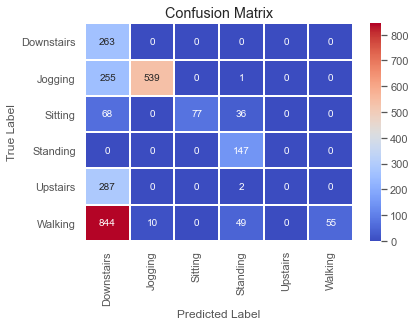

In [22]:
print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

In [23]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.15      1.00      0.27       263
           1       0.98      0.68      0.80       795
           2       1.00      0.43      0.60       181
           3       0.63      1.00      0.77       147
           4       0.00      0.00      0.00       289
           5       1.00      0.06      0.11       958

    accuracy                           0.41      2633
   macro avg       0.63      0.53      0.42      2633
weighted avg       0.78      0.41      0.39      2633



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Reducing Batch size for reducing the dangling of movement of data

In [24]:
print("\n--- Create neural network model ---\n")
from tensorflow.keras.layers import BatchNormalization
# 1D CNN neural network
model_m = Sequential()
# model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(140, 5, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(140, 5, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(70, 5, activation='relu'))
model_m.add(BatchNormalization())

model_m.add(Conv1D(70, 5, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(BatchNormalization())

model_m.add(Conv1D(40, 5, activation='relu'))
model_m.add(BatchNormalization())

model_m.add(MaxPooling1D(3))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())


--- Create neural network model ---

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 196, 140)          2240      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 192, 140)          98140     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 64, 140)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 60, 70)            49070     
_________________________________________________________________
batch_normalization_6 (Batch (None, 60, 70)            280       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 56, 70)            24570     
_________________________________________________________________
max_pooling1d_7 

In [25]:
print("\n--- Fit the model ---\n")
from tensorflow.keras import optimizers
# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
#     keras.callbacks.ModelCheckpoint(
#         filepath='best_model_91_BN_3.{epoch:02d}-{val_loss:.2f}.h5',
#         monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

adam = optimizers.Adam(lr=0.0001)

model_m.compile(loss='categorical_crossentropy',
                optimizer=adam, metrics=['accuracy'])

BATCH_SIZE = 50
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)






--- Fit the model ---

Train on 6676 samples, validate on 1670 samples
Epoch 1/25
6676/6676 [==============================] - 24s 4ms/sample - loss: 0.5398 - accuracy: 0.8330 - val_loss: 1.1892 - val_accuracy: 0.6443
Epoch 2/25
6676/6676 [==============================] - 22s 3ms/sample - loss: 0.2306 - accuracy: 0.9314 - val_loss: 1.0492 - val_accuracy: 0.6491
Epoch 3/25
6676/6676 [==============================] - 22s 3ms/sample - loss: 0.1588 - accuracy: 0.9542 - val_loss: 0.6729 - val_accuracy: 0.7575
Epoch 4/25
6676/6676 [==============================] - 22s 3ms/sample - loss: 0.1219 - accuracy: 0.9675 - val_loss: 0.4676 - val_accuracy: 0.8347
Epoch 5/25
6676/6676 [==============================] - 22s 3ms/sample - loss: 0.0963 - accuracy: 0.9760 - val_loss: 0.4510 - val_accuracy: 0.8389
Epoch 6/25
6676/6676 [==============================] - 22s 3ms/sample - loss: 0.0788 - accuracy: 0.9808 - val_loss: 0.8480 - val_accuracy: 0.7359
Epoch 7/25
6676/6676 [========================

In [26]:

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

2633/2633 [==============================] - 2s 785us/sample - loss: 0.3405 - accuracy: 0.9009

Accuracy on test data: 0.90

Loss on test data: 0.34



--- Confusion matrix for test data ---



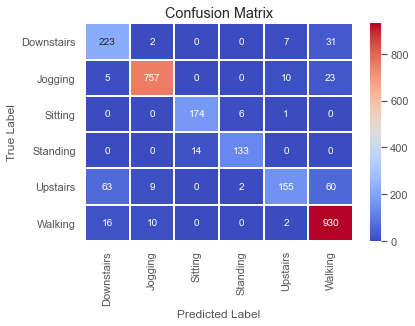

In [27]:
print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

In [28]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.73      0.85      0.78       263
           1       0.97      0.95      0.96       795
           2       0.93      0.96      0.94       181
           3       0.94      0.90      0.92       147
           4       0.89      0.54      0.67       289
           5       0.89      0.97      0.93       958

    accuracy                           0.90      2633
   macro avg       0.89      0.86      0.87      2633
weighted avg       0.90      0.90      0.90      2633



In [35]:
print("\n--- Create neural network model ---\n")
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
# 1D CNN neural network
model_m = Sequential()
# model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(140, 5, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(140, 5, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(70, 5, activation='relu'))
model_m.add(BatchNormalization())

model_m.add(Conv1D(70, 5, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(BatchNormalization())

model_m.add(Conv1D(40, 5, activation='relu'))
model_m.add(BatchNormalization())

model_m.add(MaxPooling1D(3))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.1)))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())


--- Create neural network model ---

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 196, 140)          2240      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 192, 140)          98140     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 64, 140)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 60, 70)            49070     
_________________________________________________________________
batch_normalization_15 (Batc (None, 60, 70)            280       
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 56, 70)            24570     
_________________________________________________________________
max_pooling1d_16

In [36]:
print("\n--- Fit the model ---\n")
from tensorflow.keras import optimizers
# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
#     keras.callbacks.ModelCheckpoint(
#         filepath='best_model_91_BN_3.{epoch:02d}-{val_loss:.2f}.h5',
#         monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

adam = optimizers.Adam(lr=0.0001)

model_m.compile(loss='categorical_crossentropy',
                optimizer=adam, metrics=['accuracy'])

BATCH_SIZE = 50
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)







--- Fit the model ---

Train on 6676 samples, validate on 1670 samples
Epoch 1/25
6676/6676 [==============================] - 13s 2ms/sample - loss: 2.5566 - accuracy: 0.6471 - val_loss: 2.9564 - val_accuracy: 0.5647
Epoch 2/25
6676/6676 [==============================] - 14s 2ms/sample - loss: 1.9918 - accuracy: 0.8617 - val_loss: 2.7485 - val_accuracy: 0.3754
Epoch 3/25
6676/6676 [==============================] - 14s 2ms/sample - loss: 1.7171 - accuracy: 0.8968 - val_loss: 2.5344 - val_accuracy: 0.5204
Epoch 4/25
6676/6676 [==============================] - 17s 2ms/sample - loss: 1.5125 - accuracy: 0.9139 - val_loss: 2.0052 - val_accuracy: 0.6922
Epoch 5/25
6676/6676 [==============================] - 18s 3ms/sample - loss: 1.3589 - accuracy: 0.9194 - val_loss: 1.7282 - val_accuracy: 0.7467
Epoch 6/25
6676/6676 [==============================] - 17s 3ms/sample - loss: 1.2126 - accuracy: 0.9389 - val_loss: 1.5238 - val_accuracy: 0.8054
Epoch 7/25
6676/6676 [========================

In [37]:

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

2633/2633 [==============================] - 1s 419us/sample - loss: 0.7111 - accuracy: 0.9202

Accuracy on test data: 0.92

Loss on test data: 0.71



--- Confusion matrix for test data ---



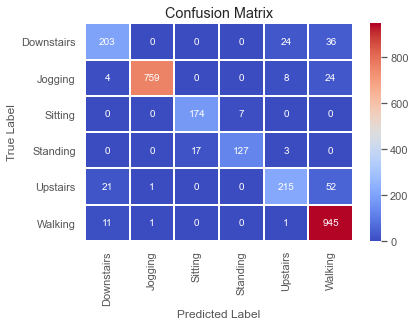

In [38]:
print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

In [39]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       263
           1       1.00      0.95      0.98       795
           2       0.91      0.96      0.94       181
           3       0.95      0.86      0.90       147
           4       0.86      0.74      0.80       289
           5       0.89      0.99      0.94       958

    accuracy                           0.92      2633
   macro avg       0.91      0.88      0.89      2633
weighted avg       0.92      0.92      0.92      2633

